In [56]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [57]:
def load_qmc_energy_data(
    data_dir,
    D="1D",
    L=12,
    N=12,
    M=12,
    l=2,
    t="1.0000",
    beta="1.0000",
    seed="2001",
    trialstate="constant"
):
    """
    Load QMC energy data files for given system parameters.

    Parameters:
        data_dir (str): Path to directory with QMC output files.
        D (str): Dimensionality, e.g. '1D' or '2D'.
        L (int): System size.
        N (int): Number of particles.
        M (int): Number of time slices or bins.
        l (int): ?
        t (str): Hopping parameter, formatted as string (e.g., '1.0000').
        beta (str): Inverse temperature, formatted as string (e.g., '1.0000').
        seed (str): Seed used in simulation.
        trialstate (str): Trial state string (e.g., 'constant').

    Returns:
        pd.DataFrame: Energy data indexed by U, including total mean and std.
    """
    tag = f"{D}_L{L}_N{N}_M{M}_l{l}"
    pattern = re.compile(
        rf"(K|V)_{tag}_U([0-9.]+)_t{t}_beta{beta}_binsize10000_seed{seed}_square_trialstate_{trialstate}\.dat"
    )

    energy_data = {}

    for fname in os.listdir(data_dir):
        match = pattern.match(fname)
        if match:
            kind = match.group(1)         # 'K' or 'V'
            U_val = float(match.group(2)) # Extract U
            fpath = os.path.join(data_dir, fname)

            df = pd.read_csv(fpath, delim_whitespace=True, header=None)
            mean = df[0].mean()
            std = df[0].std()

            if U_val not in energy_data:
                energy_data[U_val] = {}

            energy_data[U_val][f"{kind}_mean"] = mean
            energy_data[U_val][f"{kind}_std"] = std

    df_energy = pd.DataFrame.from_dict(energy_data, orient="index")
    df_energy.index.name = "U"
    df_energy.sort_index(inplace=True)

    # Compute total energy and uncertainty
    df_energy["Total_mean"] = df_energy["K_mean"] + df_energy["V_mean"]
    df_energy["Total_std"] = (df_energy["K_std"]**2 + df_energy["V_std"]**2)**0.5

    return df_energy


# 1D Benchmarking for 12 particles on 12 sites
Ran PIMC with the following:

julia pigsfli.jl -D 1 -L 12 -N 12 -l 2 -U [1.0-10.0] --sweeps 100000 --seed 2001 --measurement-frequency 25 --bin-size 10000 --bins-wanted 100 --num-replicas 1 --beta 1.0

In [98]:
# Skip the commented header line that starts with #
vmc_1D_12_12_path = "../data/1D_12_12_VMC_results.dat"
df_VMC_1D_12_12 = pd.read_csv(vmc_1D_12_12_path, delim_whitespace=True, comment='#', names=["U", "kappa", "energy", "sem"])

exact_1D_12_12path = "../data/exact_1D_12_12.dat"
df_exact_1D_12_12 = pd.read_csv(exact_1D_12_12path, delim_whitespace=True, comment="#", header=None)
df_exact_1D_12_12.columns = ["U", "Eg", "K", "V", "S₁(ℓ=5)", "S₁acc(ℓ=5)", "S₂(ℓ=5)", "S₂acc(ℓ=5)", "EN(ℓ=5)", "ENacc(ℓ=5)"]

df_qmc_1D = load_qmc_energy_data("../data/QMC/1D/")
df_1D = pd.merge(df_exact_1D_12_12, df_VMC_1D_12_12, on="U")
# df_1D.head()

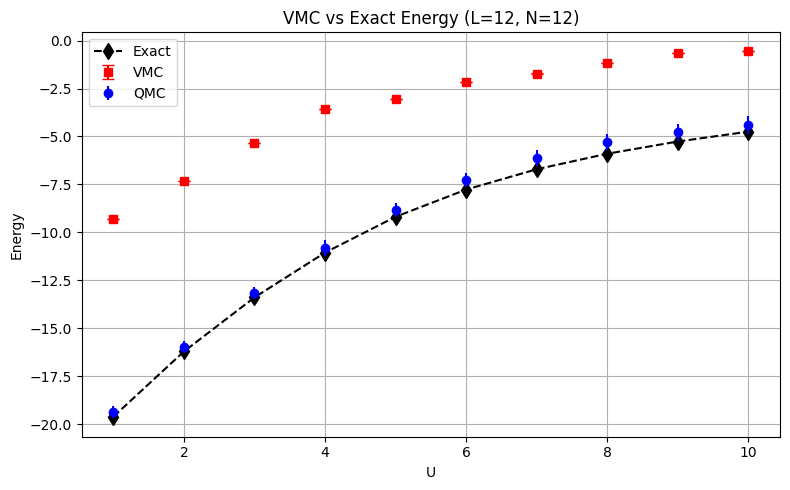

In [122]:
plt.figure(figsize=(8, 5))
plt.plot(df_1D["U"], df_1D["Eg"], label="Exact", linestyle='--', marker='d', color='black', markersize=8)
plt.errorbar(df_1D["U"], df_1D["energy"], yerr=df_1D["sem"], label="VMC", fmt='s', capsize=4, color='red')
plt.errorbar(df_qmc_1D.index, df_qmc_1D["Total_mean"], yerr=df_qmc_1D["Total_std"], label="QMC", fmt=" ", marker='o', color='blue')

plt.xlabel("U")
plt.ylabel("Energy")
plt.title("VMC vs Exact Energy (L=12, N=12)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./figures/1D_12_12.pdf", dpi=600)
plt.show()

1D Benchmarking for 16 particles on 8 sites
Ran PIMC with the following:

julia pigsfli.jl -D 1 -L 8 -N 16 -l 2 -U [1.0-10.0] --sweeps 100000 --seed 2001 --measurement-frequency 25 --bin-size 10000 --bins-wanted 100 --num-replicas 1 --beta 1.0

In [111]:
vmc_1D_8_16_path = "../data/1D_8_16_VMC_results.dat"
df_VMC_1D_8_16 = pd.read_csv(vmc_1D_8_16_path, delim_whitespace=True, comment='#', names=["U", "kappa", "energy", "sem"])
df_qmc_1D_8_16_ = load_qmc_energy_data("../data/QMC/1D_8_16/", "1D", 8, 16, 8)

exact_1D_8_16path = "../data/exact_1D_8_16.dat"
df_exact_1D_8_16 = pd.read_csv(exact_1D_8_16path, delim_whitespace=True, comment="#", header=None)
df_exact_1D_8_16.columns = ["U", "Eg", "K", "V", "S₁(ℓ=5)", "S₁acc(ℓ=5)", "S₂(ℓ=5)", "S₂acc(ℓ=5)", "EN(ℓ=5)", "ENacc(ℓ=5)"]

df_1D_8_16 = pd.merge(df_exact_1D_8_16, df_VMC_1D_8_16, on="U")

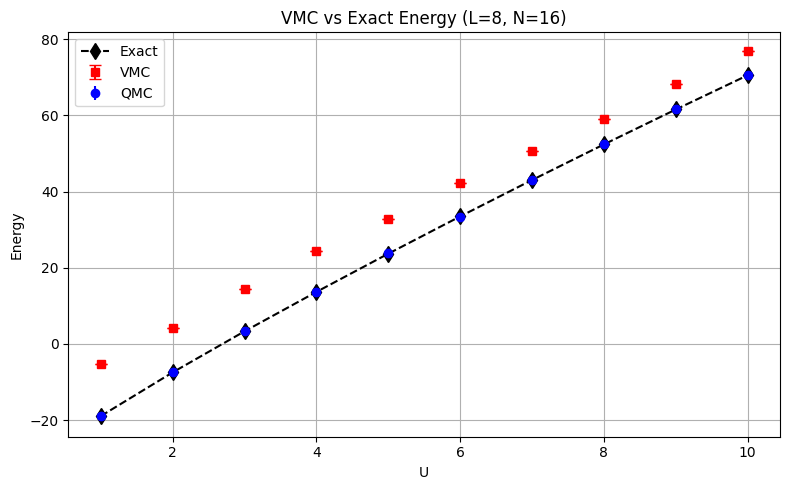

In [120]:
plt.figure(figsize=(8, 5))
plt.plot(df_1D_8_16["U"], df_1D_8_16["Eg"], label="Exact", linestyle='--', marker='d', color='black', markersize=8)
plt.errorbar(df_VMC_1D_8_16["U"], df_VMC_1D_8_16["energy"], yerr=df_VMC_1D_8_16["sem"], label="VMC", fmt='s', capsize=4, color='red')
plt.errorbar(df_qmc_1D_8_16_.index, df_qmc_1D_8_16_["Total_mean"], yerr=df_qmc_1D_8_16_["Total_std"], label="QMC", fmt=" ", marker='o', color='blue')

plt.xlabel("U")
plt.ylabel("Energy")
plt.title("VMC vs Exact Energy (L=8, N=16)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./figures/1D_8_16.pdf", dpi=600)
plt.show()

# 2D Benchmarking for 4 particles on a 2x2 lattice 
Ran PIMC with the following:

julia pigsfli.jl -D 2 -L 16 -N 16 -l 2 -U [1.0-10.0] --sweeps 100000 --seed 2001 --measurement-frequency 25 --bin-size 10000 --bins-wanted 100 --num-replicas 1 --beta 1.0

In [109]:
vmc_2D_path = "../data/2D_16_16_VMC_results.dat"
df_VMC_2D = pd.read_csv(vmc_2D_path, delim_whitespace=True, comment='#', names=["U", "kappa", "energy", "sem"])
df_qmc_2D = load_qmc_energy_data("../data/QMC/2D/", "2D", 16, 16, 256)

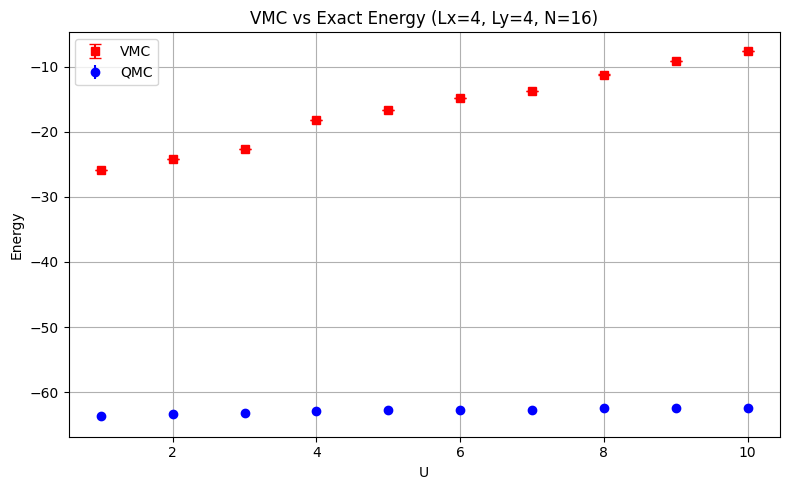

In [123]:
plt.figure(figsize=(8, 5))
plt.errorbar(df_VMC_2D["U"], df_VMC_2D["energy"], yerr=df_VMC_2D["sem"], label="VMC", fmt='s', capsize=4, color='red')
plt.errorbar(df_qmc_2D.index, df_qmc_2D["Total_mean"], yerr=df_qmc_2D["Total_std"], label="QMC", fmt=" ", marker='o', color='blue')

plt.xlabel("U")
plt.ylabel("Energy")
plt.title("VMC vs Exact Energy (Lx=4, Ly=4, N=16)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("./figures/2D_16_16.pdf", dpi=600)
plt.show()